In [5]:
from PIL import Image, ImageDraw, ImageFont
import os
import re

class ImageTextGen:
    def __init__(self, canvas_size=(128, 128), font_path=None, font_size=10, custom_space_width=None):
        """
        Inizializza il generatore.

        Args:
            canvas_size (tuple): (width, height).
            font_path (str): Path al file .ttf.
            font_size (int): Dimensione font.
            custom_space_width (int, optional):
                - Se None: usa spaziatura standard del font.
                - Se int: usa spaziatura custom per gli spazi (avanzamento fisso).
        """
        self.width, self.height = canvas_size
        self.font_size = font_size
        self.custom_space_width = custom_space_width

        if font_path and os.path.exists(font_path):
            self.font = ImageFont.truetype(font_path, font_size)
        else:
            print(f"Warning: Font '{font_path}' non trovato. Uso default.")
            self.font = ImageFont.load_default()

    def _get_line_height(self):
        """Calcola altezza riga in modo sicuro per entrambi i metodi."""
        bbox = self.font.getbbox("Hg")
        return bbox[3] - bbox[1] + 1

    def render(self, text):
        """Metodo principale che smista la logica."""
        if self.custom_space_width is not None:
            return self._render_custom(text)
        else:
            return self._render_standard(text)

    # ----------------------------
    # Helpers: char-level fitting
    # ----------------------------
    def _fit_prefix_len(self, s: str, max_w: float, measure_fn) -> int:
        """
        Ritorna la lunghezza massima del prefisso di `s` che entra in `max_w`.
        Usa binary search su measure_fn(s[:k]).
        """
        if not s:
            return 0

        eps = 1e-6
        # Se non entra nemmeno 1 char, forziamo 1 per evitare loop infinito
        if measure_fn(s[:1]) > max_w + eps:
            return 1

        lo, hi = 1, len(s)
        while lo < hi:
            mid = (lo + hi + 1) // 2
            if measure_fn(s[:mid]) <= max_w + eps:
                lo = mid
            else:
                hi = mid - 1
        return lo

    # ==========================================
    # LOGICA STANDARD (Veloce, Spaziatura Font)
    # ==========================================
    def _render_standard(self, text):
        lines = self._wrap_text_standard_charwise(text)
        line_height = self._get_line_height()

        images = []
        current_image = Image.new('L', (self.width, self.height), color=0)
        draw = ImageDraw.Draw(current_image)
        y_cursor = 0

        for line in lines:
            if y_cursor + line_height > self.height:
                images.append(current_image)
                current_image = Image.new('L', (self.width, self.height), color=0)
                draw = ImageDraw.Draw(current_image)
                y_cursor = 0

            # line può essere "" (riga vuota): ok, avanza comunque
            if line:
                draw.text((0, y_cursor), line, font=self.font, fill=255)
            y_cursor += line_height

        images.append(current_image)
        return images

    def _wrap_text_standard_charwise(self, text: str):
        """
        Wrap a livello carattere usando la misura reale del font.
        Mantiene i newline espliciti.
        """
        # Normalizza newline
        text = text.replace("\r\n", "\n").replace("\r", "\n")

        lines = []
        for paragraph in text.split("\n"):
            # Preserva righe vuote
            if paragraph == "":
                lines.append("")
                continue

            remaining = paragraph
            while remaining:
                if self.font.getlength(remaining) <= self.width:
                    lines.append(remaining.rstrip())
                    break

                k = self._fit_prefix_len(remaining, self.width, self.font.getlength)
                chunk = remaining[:k].rstrip()
                lines.append(chunk)

                remaining = remaining[k:]
                # Evita che le righe wrappate inizino con spazi (tipico comportamento)
                remaining = remaining.lstrip(" ")

        return lines

    # ==========================================
    # LOGICA CUSTOM (Precisa, Spaziatura Manuale)
    # ==========================================
    def _render_custom(self, text):
        """
        Render custom: spazi con avanzamento fisso (custom_space_width),
        testo misurato e disegnato in run (per performance/kerning interno alla run).
        """
        lines_tokens = self._wrap_text_custom_charwise(text)
        line_height = self._get_line_height()
        space_w = float(self.custom_space_width)

        data = []
        current_image = Image.new('L', (self.width, self.height), color=0)
        draw = ImageDraw.Draw(current_image)
        y_cursor = 0
        text_buff = ""

        for tokens in lines_tokens:
            if y_cursor + line_height > self.height:
                data.append((current_image, text_buff))
                current_image = Image.new('L', (self.width, self.height), color=0)
                draw = ImageDraw.Draw(current_image)
                y_cursor = 0
                text_buff = ""

            x_cursor = 0.0
            for tok in tokens:
                if tok == " ":
                    x_cursor += space_w
                else:
                    draw.text((x_cursor, y_cursor), tok, font=self.font, fill=255)
                    x_cursor += self.font.getlength(tok)

            y_cursor += line_height
            text_buff += "".join(tokens)

        if text_buff != "":
            data.append((current_image, text_buff))
        return data

    def _wrap_text_custom_charwise(self, text: str):
        """
        Wrap a livello carattere con gestione spazi a larghezza fissa.
        - Preserva newline espliciti
        - Preserva spazi multipli (ma non li mette a inizio riga dopo wrap)
        - Spezza anche parole lunghissime a livello char
        """
        text = text.replace("\r\n", "\n").replace("\r", "\n")
        # Tratta i tab come 4 spazi (puoi cambiare se ti serve)
        text = text.replace("\t", "  ")

        space_w = float(self.custom_space_width)
        lines = []

        for paragraph in text.split("\n"):
            if paragraph == "":
                lines.append([])  # riga vuota
                continue

            # Runs: o sequenze di spazi, o sequenze di non-spazi
            runs = re.findall(r" +|[^ ]+", paragraph)

            current_tokens = []
            current_w = 0.0

            def flush_line():
                nonlocal current_tokens, current_w
                lines.append(current_tokens)
                current_tokens = []
                current_w = 0.0

            for run in runs:
                if not run:
                    continue

                if run[0] == " ":
                    # Spazi: aggiungi char per char (larghezza fissa)
                    for _ in run:
                        # Evita spazi a inizio riga dopo un wrap
                        if not current_tokens:
                            continue
                        if current_w + space_w <= self.width:
                            current_tokens.append(" ")
                            current_w += space_w
                        else:
                            flush_line()
                            # dopo wrap non aggiungiamo spazi iniziali
                    continue

                # Run di testo (senza spazi): può richiedere split charwise
                remaining = run
                while remaining:
                    # Se la riga è piena, vai a capo
                    if current_tokens and current_w >= self.width:
                        flush_line()

                    remaining_w = self.width - current_w
                    run_w = self.font.getlength(remaining)

                    if run_w <= remaining_w:
                        current_tokens.append(remaining)
                        current_w += run_w
                        remaining = ""
                    else:
                        k = self._fit_prefix_len(remaining, remaining_w, self.font.getlength)
                        part = remaining[:k]
                        part_w = self.font.getlength(part)

                        # Safety: se non entra nulla (caso limite), forza 1 char
                        if k <= 0:
                            part = remaining[:1]
                            part_w = self.font.getlength(part)
                            remaining = remaining[1:]
                        else:
                            remaining = remaining[k:]

                        current_tokens.append(part)
                        current_w += part_w
                        flush_line()

            # Chiudi l'ultima linea del paragraph (anche se vuota)
            lines.append(current_tokens)

        return lines


In [2]:
from pathlib import Path


def build_dataset(paths: list[Path]):

    doc = ""

    for p in paths:
        doc += " " + p.read_text().replace("\n", " ")
    
    return doc

base_p = Path("/Users/mascit/projects/semagna/blogutils/notebooks/data.tmp")
paths = list(Path(base_p / "papers/").rglob("*_done.md")) + list(Path(base_p / "weeklies/").rglob("*_.md")) + list(Path(base_p / "other/").rglob("*_done.md")) 

long_text = build_dataset(paths)
len(long_text)

1485290

In [ ]:


gen = ImageTextGen(
    canvas_size=(128, 128), 
    font_path="/Users/mascit/Downloads/CozetteVector.ttf", #"/Users/mascit/Downloads/unifont-17.0.03.otf", #"/Users/mascit/Downloads/CozetteVector.ttf", #"/Users/mascit/Downloads/04b_03/04B_03__.TTF",
    font_size=10,
    custom_space_width=3
)

result_images = gen.render(long_text)

print(f"Generated {len(result_images)} images.")

Generated 4419 images.


In [10]:
out_dir = Path("/Volumes/Lexar/datasets/textimgzip")
out_dir.mkdir(parents=True, exist_ok=True)

In [11]:
from datasets import DatasetDict, Dataset

rows = []
for i, (img, txt) in enumerate(result_images):

    row = {"pixel_values": img, "text": txt}
    rows.append(row)

ds = Dataset.from_list(rows)
ds_dict = ds.train_test_split(train_size=0.8, seed=42)

ds_dict.save_to_disk(out_dir)

Saving the dataset (1/1 shards): 100%|██████████| 884/884 [00:00<00:00, 72357.92 examples/s]


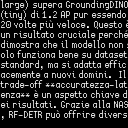

In [14]:
ds_dict["train"][0]["pixel_values"]